#### 根据对称性进行聚类，并绘制聚类结果。给出每个对称的不可约表示，组合成一个转换矩阵，并求出分块矩阵。

ref: Pecora, L.M.: Cluster synchronization and isolated desynchronization in complex networks with symmetries. Nat. Commun. 5, 4079 (2014).

In [33]:
import networkx as nx
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt

#### 集合网络对称性分析工具

In [34]:
class GraphSymmetryAnalyzer:
    """
        依赖  python-igraph  +  numpy
        get_group_size()  -> 自同构群大小(int)
        get_group()       -> 所有自同构映射  list[dict]
        get_orbits()      -> 轨道列表(潜在簇)list[list[int]]

        参数说明：
            ----------
            adj_matrix : np.ndarray
                邻接矩阵，支持有向 / 无向 (仅拓扑参与同构)
            directed : bool
                是否为有向图，默认为 False
    """
    def __init__(self, adj_matrix, directed=False):
        # ---- 建图 ----
        A = np.asarray(adj_matrix, dtype=int)
        self.N = len(A)
        self.directed = directed

        self.G = ig.Graph.Adjacency((A > 0).tolist(), mode="directed" if directed else "undirected")
        # ---- 计算自同构群 ----
        self._autos = self.G.get_automorphisms_vf2()

    def get_group_size(self):
        """返回自同构群的大小"""
        return len(self._autos)

    def get_group(self):
        """返回所有自同构映射的列表（每个为 dict: 节点编号的置换）"""
        return [dict(enumerate(p)) for p in self._autos]

    def get_group_matrices(self):
        """返回所有自同构的置换矩阵表示（每个为 N x N 的 numpy 矩阵）"""
        self._permutation_matrices = []
        for perm in self._autos:
            P = np.zeros((self.N, self.N))
            for i, j in enumerate(perm):
                P[j, i] = 1
            self._permutation_matrices.append(P)
        return self._permutation_matrices

    def get_orbits(self):
        """返回轨道（即在自同构群下可互换的节点集合）"""
        reach = [set([i]) for i in range(self.N)]
        for perm in self._autos:
            for i, j in enumerate(perm):
                reach[i].add(j)
                reach[j].add(i)

        # 合并成轨道（BFS 方式）
        seen = set()
        orbits = []
        for i in range(self.N):
            if i in seen:
                continue
            stack = [i]
            orbit = set([i])
            while stack:
                node = stack.pop()
                for neighbor in reach[node]:
                    if neighbor not in orbit:
                        orbit.add(neighbor)
                        stack.append(neighbor)
            orbits.append(sorted(orbit))
            seen.update(orbit)
        return orbits
    
    def plot_orbits(self, node_size=600):
        """绘制图并以不同颜色显示轨道（簇）"""
        orbits = self.get_orbits()

        # 创建 networkx 图
        A = np.asarray(self.G.get_adjacency().data)
        G_nx = nx.from_numpy_array(A, create_using=nx.DiGraph if self.directed else nx.Graph)

        # 颜色设置
        cmap = plt.get_cmap('tab20')
        color_map = ['gray'] * self.N
        for idx, orbit in enumerate(orbits):
            for node in orbit:
                color_map[node] = cmap(idx % 20)
        
         # 设置布局和标签
        pos = nx.spring_layout(G_nx, seed=42)
        labels = {i: str(i + 1) for i in range(self.N)}  # 节点标签从1开始

        plt.figure(figsize=(8, 6))
        nx.draw(G_nx, pos, labels=labels, with_labels=True, node_color=color_map,
                edge_color='lightgray', node_size=node_size, font_size=10)
    
        plt.title("Track clustering diagram (Node colors represent the same track)", fontsize=14)
        plt.axis('off')
        plt.show()

#### 文章中给的例子

In [35]:
# 32个对称组，
A = np.array([
        [0,1,1,1,0,1,1,1,1,1,1],
        [1,0,1,1,1,1,0,1,1,1,1],
        [1,1,0,1,1,1,1,1,0,1,1],
        [1,1,1,0,1,1,1,1,1,1,1],
        [0,1,1,1,0,1,1,1,1,1,0],
        [1,1,1,1,1,0,1,1,1,1,1],
        [1,0,1,1,1,1,0,1,1,1,1],
        [1,1,1,1,1,1,1,0,1,0,1],
        [1,1,0,1,1,1,1,1,0,1,1],
        [1,1,1,1,1,1,1,0,1,0,0],
        [1,1,1,1,0,1,1,1,1,0,0]
    ])

G = GraphSymmetryAnalyzer(A)
print("自同构群大小:", G.get_group_size())
print("轨道列表:", G.get_orbits())
# print("所有自同构映射:", G.get_group())
# print("所有自同构映射的置换矩阵:", G.get_group_matrices())
# G.get_transformation_operator()

自同构群大小: 32
轨道列表: [[0, 7], [1, 2, 6, 8], [3, 5], [4, 9], [10]]


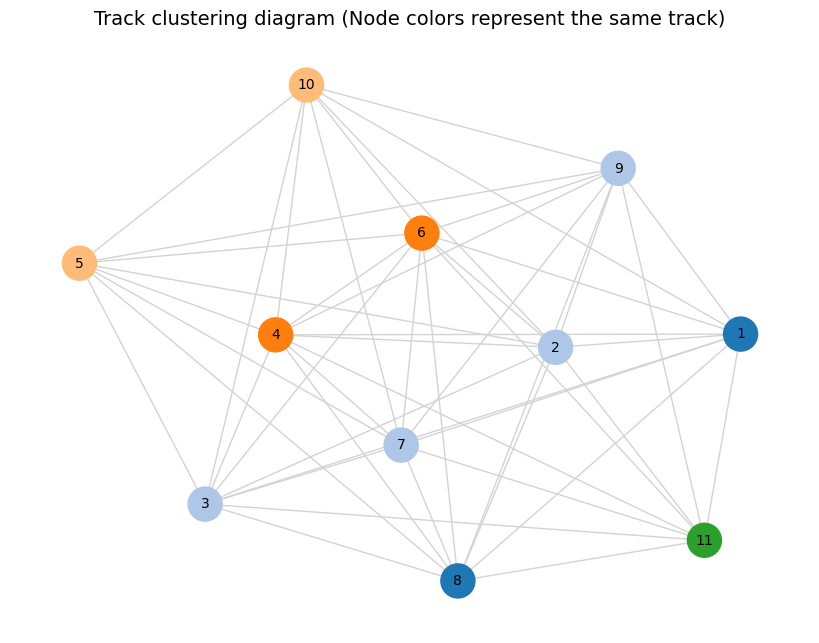

In [36]:
G.plot_orbits()